In [1]:
import pydra

import matplotlib.pyplot as plt
import sklearn

A newer version (0.4) of nipype/pydra is available. You are using 0.3.1+47.g665ddc5.dirty


# Machine Learning Workflow

Hyperparameter tuning is an important step in developing machine learning models.  
XXX You learned how to run multiple tasks within a pipeline with *pydra* `Workflow` in the `intro_workflow` tutorial.  


Let's initiate a `Workflow` with **MNIST** data as input: 

In [2]:
from sklearn import datasets

digits = datasets.load_digits(n_class=10, return_X_y=False)

In [3]:
digits.images[1]

array([[ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16.,  9.,  0.,  0.],
       [ 0.,  0.,  3., 15., 16.,  6.,  0.,  0.],
       [ 0.,  7., 15., 16., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  3.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  1., 16., 16.,  6.,  0.,  0.],
       [ 0.,  0.,  0., 11., 16., 10.,  0.,  0.]])

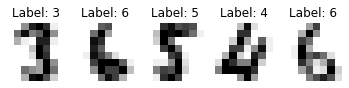

In [4]:
import random
random.seed(10)

_, axes = plt.subplots(1, 5)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[:], random.sample(images_and_labels, 5)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % label)

Let's build a workflow with one model only to start.  Here we use SVM (Support Vector Machine) for classification

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

## Define `FunctionTask`

In [6]:
import typing as ty

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
# linear SVM
@pydra.mark.task
@pydra.mark.annotate({"return": {"clf": ty.Any}})
def fit_SVM(X_tr, y_tr, C=1, kernel='rbf', gamma=1):
    from sklearn.svm import SVC
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_tr, y_tr)
    return(clf)

# metrics
from sklearn import metrics
@pydra.mark.task
@pydra.mark.annotate({"return": {"score": ty.Any}})
def metric_score(clf, X_tt, y_tt, metric):
    
    y_pred = clf.predict(X_tt)
    
    from sklearn import metrics
    if metric == 'accuracy':
        score = metrics.accuracy_score(y_tt, y_pred)
    elif metric == 'precision':
        score = metrics.precision_score(y_tt, y_pred, average='micro')
    else:
        score = metrics.recall_score(y_tt, y_pred, average='micro')
    return(score)
    

In [7]:
X_test.shape

(899, 64)

# Create workflow

In [8]:
input_grid = {'X_tr': X_train,
              'X_tt': X_test,
              'y_tr': y_train,
              'y_tt': y_test,
              'C': [0.1, 1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001], #'gamma': ['scale', 'auto'],
              'kernel': 'rbf',
              'metric': ['accuracy', 'precision', 'recall']}

In [9]:
# Working!
wf = pydra.Workflow(name="svm", 
                     input_spec=list(input_grid.keys()), **input_grid)

wf.split(['gamma', 'C', 'metric'])
wf.add(fit_SVM(name='fit_clf', 
                X_tr=wf.lzin.X_tr, y_tr=wf.lzin.y_tr, kernel=wf.lzin.kernel,
                C=wf.lzin.C, gamma=wf.lzin.gamma))  

wf.add(metric_score(name='calc_metric', 
                     clf=wf.fit_clf.lzout.clf, metric=wf.lzin.metric,
                     X_tt=wf.lzin.X_tt, y_tt=wf.lzin.y_tt))
        
wf.set_output([("score", wf.calc_metric.lzout.score)])

with pydra.Submitter(plugin="cf") as sub:
    sub(wf)

wf.result()

[Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.10122358175750834), runtime=None, errored=False),
 Result(output=Output(score=0.1012235817